In [1]:
!pip install netCDF4
!pip install rocketpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65875 sha256=5404427719851012909034ca36f99ec24978e6d864f228ced599598395e3f735
  Stored in directory: /root/.cache/pip/wheels/61/7c/b1/a15afd1959498020ff45abc6e309b5c48975a5d741e60c5922
Successfully built simplekml
  Attempting uninstall: netCDF4
    Found existing installation: netCD

In [2]:
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display

In [3]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

In [50]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (
        17.503,
        0.1,
    ),  # Rocket's dry mass (kg) and its uncertainty (standard deviation)
    # Propulsion Details - run help(SolidMotor) for more information
    "impulse": (3768.996, 50),  # Motor total impulse (N*s)
    "burnOut": (2.6, .1),  # Motor burn out time (s)
    "nozzleRadius": (0.023813, 0.5 / 1000),  # Motor's nozzle radius (m)
    "throatRadius": (0.0086995, 0.5 / 1000),  # Motor's nozzle throat radius (m)
    "grainSeparation": (
        0.0016,
        1 / 1000,
    ),  # Motor's grain separation (axial distance between two grains) (m)
    "grainDensity": (1625, 50),  # Motor's grain density (kg/m^3)
    "grainOuterRadius": (0.031661, 0.375 / 1000),  # Motor's grain outer radius (m)
    "grainInitialInnerRadius": (
        0.011112,
        0.375 / 1000,
    ),  # Motor's grain inner radius (m)
    "grainInitialHeight": (0.1318, 1 / 1000),  # Motor's grain height (m)
    # Aerodynamic Details - run help(Rocket) for more information
    "inertiaI": (
        10.185,
        0.03675,
    ),  # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "inertiaZ": (
        0.0528,
        0.00007,
    ),  # Rocket's inertia moment relative to its axis (kg*m^2)
    "radius": (0.07835, 0.001),  # Rocket's radius (m)
    "distanceRocketNozzle": (
        1.375,
        0.001,
    ),  # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "distanceRocketPropellant": (
        -0.89,
        0.001,
    ),  # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "noseLength": (0.76, 0.001),  # Rocket's nose cone length (m)
    "noseDistanceToCM": (
        0.8,
        0.001,
    ),  # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "finSpan": (0.15, 0.0005),  # Fin span (m)
    "finRootChord": (0.26, 0.0005),  # Fin root chord (m)
    "finTipChord": (0.1, 0.0005),  # Fin tip chord (m)
    "finDistanceToCM": (
        -0.955,
        0.001,
    ),  # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    # Launch and Environment Details - run help(Environment) and help(Flight) for more information
    "inclination": (
        90,
        2,
    ),  # Launch rail inclination angle relative to the horizontal plane (degrees)
    "heading": (270,20),  # Launch rail heading relative to north (degrees)
    "railLength": [3.66],  # Launch rail length (m)
    # Parachute Details - run help(Rocket) for more information
    "CdSDrogue": (
        0.4,
        0.02,
    ),  # Drag coefficient times reference area for the drogue chute (m^2)
    "CdSMain": (
        15.55,
        0.05,
    ),  # Drag coefficient times reference area for the drogue chute (m^2)
    "lag_drogue": (
        1.5,
        0.2,
    ),  # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    # Electronic Systems Details - run help(Rocket) for more information
    "lag_main": (
        1.5,
        0.2,
    ),  # Time delay between sensor signal is received and ejection signal is fired (s)
}

In [51]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] = normal(*parameter_value)
            else:
                flight_setting[parameter_key] = choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting["lag_drogue"] < 0 or flight_setting["lag_main"] < 0:
            continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

In [44]:
def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {
        "outOfRailTime": flight_data.outOfRailTime,
        "outOfRailVelocity": flight_data.outOfRailVelocity,
        "apogeeTime": flight_data.apogeeTime,
        "apogeeAltitude": flight_data.apogee - Env.elevation,
        "apogeeX": flight_data.apogeeX,
        "apogeeY": flight_data.apogeeY,
        "impactTime": flight_data.tFinal,
        "impactX": flight_data.xImpact,
        "impactY": flight_data.yImpact,
        "impactVelocity": flight_data.impactVelocity,
        "initialStaticMargin": flight_data.rocket.staticMargin(0),
        "outOfRailStaticMargin": flight_data.rocket.staticMargin(
            TestFlight.outOfRailTime
        ),
        "finalStaticMargin": flight_data.rocket.staticMargin(
            TestFlight.rocket.motor.burnOutTime
        ),
        "numberOfEvents": len(flight_data.parachuteEvents),
        "executionTime": exec_time,
    }

    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(
        sol[:, [0, 4]], "Time (s)", "Vx (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vy = Function(
        sol[:, [0, 5]], "Time (s)", "Vy (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vz = Function(
        sol[:, [0, 6]], "Time (s)", "Vz (m/s)", "linear", extrapolation="natural"
    )
    flight_data.v = (
        flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2
    ) ** 0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result["maxVelocity"] = flight_data.maxVel

    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result["drogueTriggerTime"] = flight_data.parachuteEvents[0][0]
        flight_result["drogueInflatedTime"] = (
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
        flight_result["drogueInflatedVelocity"] = flight_data.v(
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
    else:
        flight_result["drogueTriggerTime"] = 0
        flight_result["drogueInflatedTime"] = 0
        flight_result["drogueInflatedVelocity"] = 0

    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + "\n")
    dispersion_output_file.write(str(flight_result) + "\n")


def export_flight_error(flight_setting):
    dispersion_error_file.write(str(flight_setting) + "\n")

In [60]:
# Basic analysis info
filename = "/content/drive/MyDrive/Rocketpy/dispersion_analysis_outputs/rocket"
number_of_simulations = 1000

# Create data files for inputs, outputs and error logging
dispersion_error_file = open(str(filename) + ".disp_errors.txt", "w")
dispersion_input_file = open(str(filename) + ".disp_inputs.txt", "w")
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "w")

# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()

# Define basic Environment object
Env= Environment(
    railLength=3.66,
    latitude=35.1431,
    longitude=-76.8126,
    elevation=5,
    date=(2023, 2, 26, 16),
)
Env.setElevation(5)
URL = "http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2023&MONTH=02&FROM=2612&TO=2618&STNM=72305"

Env.setAtmosphericModel(type="WyomingSounding", file=URL)

# Iterate over flight settings
out = display("Starting", display_id=True)
for setting in flight_settings(analysis_parameters, number_of_simulations):
    start_time = process_time()
    i += 1

    # Update environment object
    Env.railLength = setting["railLength"]

    # Create motor
    L1520T = SolidMotor(
        thrustSource="/content/drive/MyDrive/Rocketpy/AeroTech_L1520T.eng",
        burnOut=5.274,
        reshapeThrustCurve=(setting["burnOut"], setting["impulse"]),
        nozzleRadius=setting["nozzleRadius"],
        throatRadius=setting["throatRadius"],
        grainNumber=3,
        grainSeparation=setting["grainSeparation"],
        grainDensity=setting["grainDensity"],
        grainOuterRadius=setting["grainOuterRadius"],
        grainInitialInnerRadius=setting["grainInitialInnerRadius"],
        grainInitialHeight=setting["grainInitialHeight"],
        interpolationMethod="linear",
    )

    # Create rocket
    FullScale = Rocket(
        motor=L1520T,
        radius=setting["radius"],
        mass=setting["rocketMass"],
        inertiaI=setting["inertiaI"],
        inertiaZ=setting["inertiaZ"],
        distanceRocketNozzle=setting["distanceRocketNozzle"],
        distanceRocketPropellant=setting["distanceRocketPropellant"],
        powerOffDrag="/content/drive/MyDrive/Rocketpy/OR_power_off_validated.csv",
        powerOnDrag="/content/drive/MyDrive/Rocketpy/OR_power_on_validated.csv",
    )
    FullScale.setRailButtons([-0.275, -1.185]) 
    # Add rocket nose, fins and tail
    NoseCone = FullScale.addNose(
        length=setting["noseLength"],
        kind="ogive",
        distanceToCM=setting["noseDistanceToCM"],
    )
    FinSet = FullScale.addTrapezoidalFins(
        n=4,
        span=setting["finSpan"],
        rootChord=setting["finRootChord"],
        tipChord=setting["finTipChord"],
        distanceToCM=setting["finDistanceToCM"],
        radius=None,
        cantAngle=0,
        airfoil=None,
    )

    def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
      return True if y[5] < 0 else False


    def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
      return True if y[5] < 0 and y[2] < 140 + Env.elevation else False

    Main = FullScale.addParachute(
        "Main",
        setting["CdSMain"],
        trigger=mainTrigger,
        samplingRate=105,
        lag=setting["lag_main"],
        noise=(0, 8.3, 0.5),
    )

    # Add parachute
    Drogue = FullScale.addParachute(
        "Drogue",
        CdS=setting["CdSDrogue"],
        trigger=drogueTrigger,
        samplingRate=105,
        lag=setting["lag_drogue"],
        noise=(0, 8.3, 0.5),
    )

    # Run trajectory simulation
    try:
        TestFlight = Flight(
            rocket=FullScale,
            environment=Env,
            inclination=setting["inclination"],
            heading=setting["heading"],
            maxTime=600,
        )
        export_flight_data(setting, TestFlight, process_time() - start_time)
    except Exception as E:
        print(E)
        export_flight_error(setting)

    # Register time
    out.update(
        f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s"
    )

# Done

## Print and save total time
final_string = f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
out.update(final_string)
dispersion_input_file.write(final_string + "\n")
dispersion_output_file.write(final_string + "\n")
dispersion_error_file.write(final_string + "\n")

## Close files
dispersion_input_file.close()
dispersion_output_file.close()
dispersion_error_file.close()

'Completed 1000 iterations successfully. Total CPU time: 1076.076714668 s. Total wall time: 1084.8974890708923 s'

In [61]:
filename = "/content/drive/MyDrive/Rocketpy/dispersion_analysis_outputs/rocket"

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {
    "outOfRailTime": [],
    "outOfRailVelocity": [],
    "apogeeTime": [],
    "apogeeAltitude": [],
    "apogeeX": [],
    "apogeeY": [],
    "impactTime": [],
    "impactX": [],
    "impactY": [],
    "impactVelocity": [],
    "initialStaticMargin": [],
    "outOfRailStaticMargin": [],
    "finalStaticMargin": [],
    "numberOfEvents": [],
    "maxVelocity": [],
    "drogueTriggerTime": [],
    "drogueInflatedTime": [],
    "drogueInflatedVelocity": [],
    "executionTime": [],
}

# Get all dispersion results
# Get file
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "r+")

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != "{":
        continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print("Number of simulations: ", N)

Number of simulations:  1000


Apogee Altitude -         Mean Value: 1312.559 m
Apogee Altitude - Standard Deviation: 30.082 m


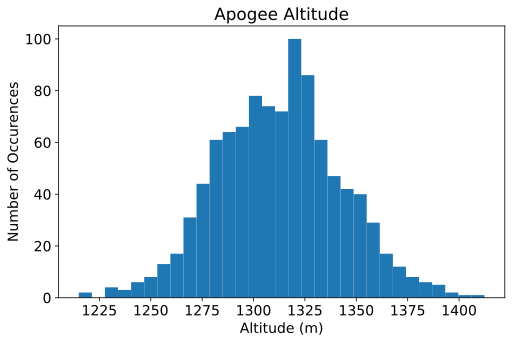

In [66]:
print(
    f'Apogee Altitude -         Mean Value: {np.mean(dispersion_results["apogeeAltitude"]):0.3f} m'
)
print(
    f'Apogee Altitude - Standard Deviation: {np.std(dispersion_results["apogeeAltitude"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["apogeeAltitude"], bins=int(N**0.5))
plt.title("Apogee Altitude")
plt.xlabel("Altitude (m)")
plt.ylabel("Number of Occurences")
plt.savefig("Apogee" + ".png", bbox_inches="tight", pad_inches=0)
plt.show()

# Real measured apogee for Valetudo = 860 m

Impact Time -         Mean Value: 86.989 s
Impact Time - Standard Deviation: 2.129 s


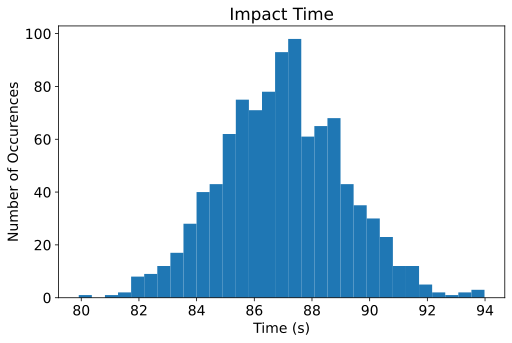

In [65]:
print(
    f'Impact Time -         Mean Value: {np.mean(dispersion_results["impactTime"]):0.3f} s'
)
print(
    f'Impact Time - Standard Deviation: {np.std(dispersion_results["impactTime"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["impactTime"], bins=int(N**0.5))
plt.title("Impact Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.savefig("ImpactTime" + ".png", bbox_inches="tight", pad_inches=0)
plt.show()

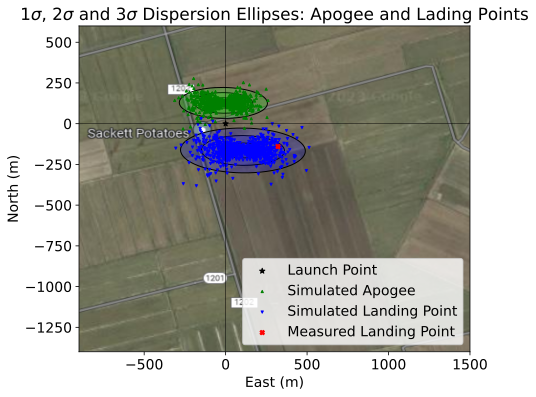

In [64]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("/content/drive/MyDrive/Rocketpy/farm.PNG")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results["apogeeX"])
apogeeY = np.array(dispersion_results["apogeeY"])
impactX = np.array(dispersion_results["impactX"])
impactY = np.array(dispersion_results["impactY"])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(
        xy=(np.mean(impactX), np.mean(impactY)),
        width=impactW * j,
        height=impactH * j,
        angle=impactTheta,
        color="black",
    )
    impactEll.set_facecolor((0, 0, 1, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(
        xy=(np.mean(apogeeX), np.mean(apogeeY)),
        width=apogeeW * j,
        height=apogeeH * j,
        angle=apogeeTheta,
        color="black",
    )
    apogeeEll.set_facecolor((0, 1, 0, 0.2))
    ax.add_artist(apogeeEll)

# Draw launch point
plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
# Draw apogee points
plt.scatter(apogeeX, apogeeY, s=5, marker="^", color="green", label="Simulated Apogee")
# Draw impact points
plt.scatter(
    impactX, impactY, s=5, marker="v", color="blue", label="Simulated Landing Point"
)
################################### Draw real landing point
plt.scatter(
    321.89, -140.07, s=20, marker="X", color="red", label="Measured Landing Point"
)

plt.legend()

# Add title and labels to plot
ax.set_title(
    "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points"
)
ax.set_ylabel("North (m)")
ax.set_xlabel("East (m)")

# Add background image to plot
# You can translate the basemap by changing dx and dy (in meters)
dx = -300
dy = 400
plt.imshow(img, zorder=0, extent=[-1200 - dx, 1200 - dx, -1000 - dy, 1000 - dy])
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)

# Save plot and show result
plt.savefig(str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(str(filename) + ".png", bbox_inches="tight", pad_inches=0)
plt.show()